In [57]:
%reset -sf

import sys
sys.path.insert(0, '..')
import get_data as gd
import atlas_plot as ap
plot = ap.Plotter()

import pandas as pd
import numpy as np
import scipy as sp

import os
import glob
import shutil

from matplotlib import pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # suppress tensorflow imformation messages

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_memory_growth(gpus[1], True)
print(tf.__version__)
print(tf.config.list_physical_devices(), end='\n\n')

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]



In [58]:
SEED = 42  # set random seed (global variable)
np.random.seed(SEED)
processor = gd.DataProcessor()
path = "/root/data/truth/signal/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 128

['/root/data/truth/signal/CGLMP.npz', '/root/data/truth/signal/Higgs.npz', '/root/data/truth/signal/LeadLepton.npz', '/root/data/truth/signal/LeptonM.npz', '/root/data/truth/signal/LeptonP.npz', '/root/data/truth/signal/LmNu.npz', '/root/data/truth/signal/LpNu.npz', '/root/data/truth/signal/MET.npz', '/root/data/truth/signal/WmBoson.npz', '/root/data/truth/signal/WpBoson.npz', '/root/data/truth/signal/diLepton.npz', '/root/data/truth/signal/subLeadLepton.npz', '/root/data/truth/signal/xi_xyz.npz']



In [59]:
## Global variables

GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 35 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

BATCH_SIZE = 1024
EPOCHS = 1024
LEARNING_RATE = 1e-3

w_lead shape: (2928862, 9)
               E            px            py             pz             m  \
0  114813.382812 -16190.328125  63319.132812   50221.468750  79927.953125   
1  450737.750000  70425.804688   3821.072266  438394.468750  77462.359375   
2  102566.046875 -10254.437500  45208.792969   79655.101562  45009.675781   

             pt       eta       phi         y  
0  65356.249165  0.707823  1.821127  0.469034  
1  70529.387911  2.526646  0.054204  2.138567  
2  46357.183371  1.310057  1.793846  1.036803  
                  E            px            py            pz             m  \
count  2.928862e+06  2.928862e+06  2.928862e+06  2.928862e+06  2.928862e+06   
mean   2.283278e+05 -1.788823e+01  1.700620e+01  2.688194e+02  7.062466e+04   
std    2.440128e+05  3.510948e+04  3.504798e+04  3.222953e+05  1.877761e+04   
min    1.596886e+04 -1.474598e+06 -7.555793e+05 -4.386726e+06  2.000148e+03   
25%    9.528028e+04 -1.782399e+04 -1.778516e+04 -1.062248e+05  7.283715e+04  

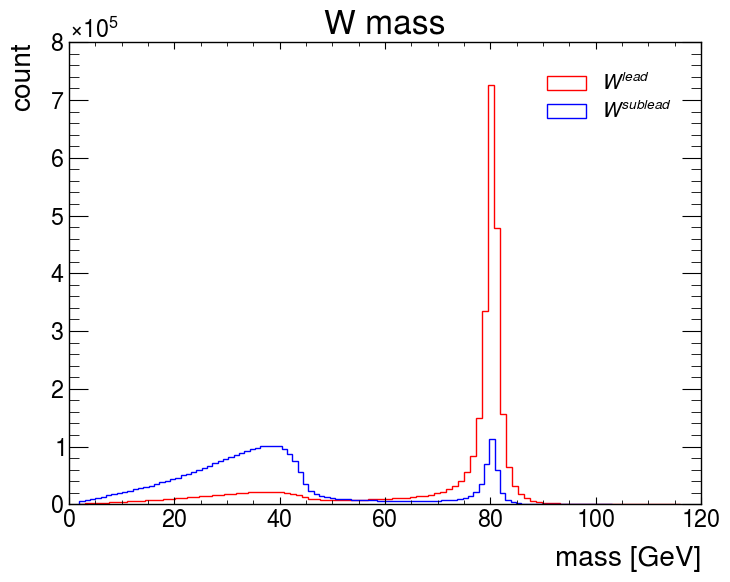

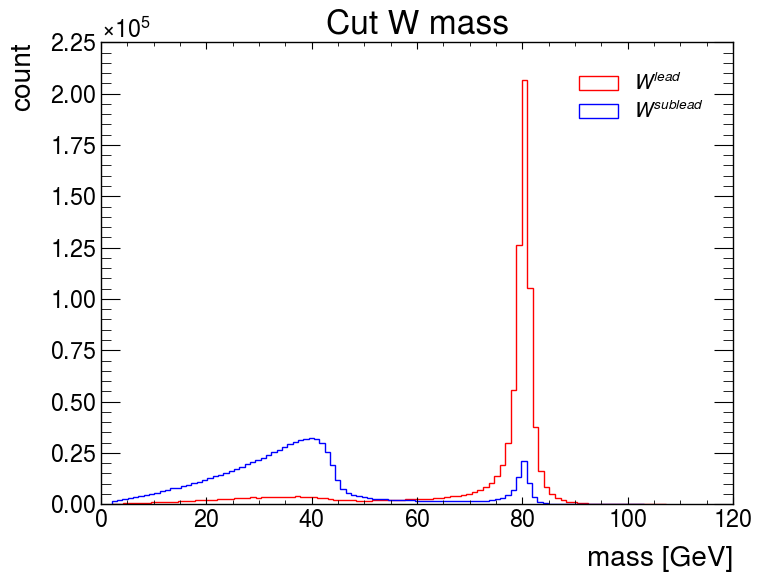

int_kin shape: (818787, 5)
           px         py          pz           E          m
7   51.956258  -3.569852    8.569077   53.066578   5.516875
10  14.993149  21.866621  170.343312  189.035875  77.554992
13  25.884557  -0.536444  684.318688  687.625188  62.177258
                  px             py             pz              E  \
count  818787.000000  818787.000000  818787.000000  818787.000000   
mean       -0.049246       0.028934       0.579341     239.651155   
std        43.875556      43.804569     328.961850     245.348492   
min      -801.031875    -755.579313   -3870.673500      32.253930   
25%       -20.922979     -20.860776    -113.232582     101.072324   
50%        -0.032517       0.009834       0.384410     150.487359   
75%        20.846591      20.919117     113.742719     272.792984   
max       857.240125     760.802688    3477.601500    3873.027750   

                   m  
count  818787.000000  
mean       72.683137  
std        16.900930  
min         2.02144

In [60]:
## Interesting variables

# Critria for leading and subleading lepton
lead_p = data.LeadLep["m"] == data.LepP["m"]
sublead_p = ~lead_p
lead_m = sublead_p.copy()
sublead_m = lead_p.copy()

# (sub)lead W
w_lead = pd.concat([data.Wp[lead_p], data.Wm[lead_m]], axis=0).sort_index()
w_sublead = pd.concat([data.Wp[sublead_p], data.Wm[sublead_m]], axis=0).sort_index()
print("w_lead shape:", w_lead.shape)
print(w_lead.head(3))
print(w_lead.describe())

# Check (sub)lead W
plt.hist(w_lead["m"] / GEV, bins=100, color="r", histtype="step", label=r"$W^{lead}$")
plt.hist(
    w_sublead["m"] / GEV, bins=100, color="b", histtype="step", label=r"$W^{sublead}$"
)
plt.title("W mass")
plt.xlabel("mass [GeV]")
plt.ylabel("count")
plt.legend(loc="best")
plt.show()
plt.close()
# Check (sub)lead W
plt.hist(
    w_lead["m"][PRE_CUT] / GEV,
    bins=100,
    color="r",
    histtype="step",
    label=r"$W^{lead}$",
)
plt.hist(
    w_sublead["m"][PRE_CUT] / GEV,
    bins=100,
    color="b",
    histtype="step",
    label=r"$W^{sublead}$",
)
plt.title("Cut W mass")
plt.xlabel("mass [GeV]")
plt.ylabel("count")
plt.legend(loc="best")
plt.show()
plt.close()

# Kinematics of interesting variables (target for training)
int_kin = w_lead[["px", "py", "pz", "E", "m"]][PRE_CUT] / GEV
print("int_kin shape:", int_kin.shape)
print(int_kin.head(3))
print(int_kin.describe())
# int_kin = int_kin.to_numpy() # convert to numpy array
# STDSCALAR_INT = StandardScaler()
# int_kin = STDSCALAR_INT.fit_transform(int_kin)
ROBUST_INT = RobustScaler()
int_kin = ROBUST_INT.fit_transform(int_kin)
# MINMAX_INT = MinMaxScaler()
# int_kin = MINMAX_INT.fit_transform(int_kin)
print(type(int_kin))

In [61]:
## Observing variables

met = data.MET[["px", "py"]]
lead_lep = data.LeadLep[["E", "px", "py", "pz"]]
sublead_lep = data.SubLep[["E", "px", "py", "pz"]]

# Kinematics of observing variables (inputs for training)
obs_kin = pd.concat([lead_lep, sublead_lep, met], axis=1)[PRE_CUT] / GEV
print("int_kin shape:", obs_kin.shape)
print(obs_kin.head(3))
print(print(obs_kin.describe()))
# obs_kin = obs_kin.to_numpy() # convert to numpy array
STDSCALAR_OBS = StandardScaler()
obs_kin = STDSCALAR_OBS.fit_transform(obs_kin)
print(type(obs_kin))

int_kin shape: (818787, 10)
             E         px         py          pz          E         px  \
7    43.361348  42.407754  -4.632000    7.767462  19.500895  -4.561588   
10   90.238664 -23.868604  32.986602   80.530680  47.669113 -26.605045   
13  232.377734  32.306596  17.332070  229.467391  52.595516  12.459787   

           py         pz         px         py  
7   18.924410  -1.154271  96.335650  47.095450  
10 -17.256748  35.590859  44.222846 -15.383637  
13   9.784288  50.152863 -35.807631   4.480668  


                   E             px             py             pz  \
count  818787.000000  818787.000000  818787.000000  818787.000000   
mean      140.029975      -0.056942       0.046832       0.256807   
std       156.031171      39.790515      39.709621     201.975068   
min        35.004121    -677.544000    -516.271844   -2858.096000   
25%        55.090303     -32.398804     -32.335277     -63.603441   
50%        84.761898      -0.126954       0.156672       0.114689   
75%       157.697109      32.311559      32.334848      64.057291   
max      2858.378750     835.569250     582.242313    2833.087750   

                   E             px             py             pz  \
count  818787.000000  818787.000000  818787.000000  818787.000000   
mean       75.789967      -0.031027      -0.001705       0.026455   
std        93.234080      20.211034      20.180580     116.708915   
min        15.003240    -313.736094    -284.251406   -2193.885000   
25%        28.033159     -15.5220

In [62]:
# Train test split

indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.6,
    test_size=0.4,
    random_state=SEED,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=SEED
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)

X (Interest)
Training data shape: (491272, 10);
Validing data shape: (163757, 10);
Testing data shape: (163758, 10).
Y (Observed)
Training data shape: (491272, 5);
Validing data shape: (163757, 5);
Testing data shape: (163758, 5).


In [63]:
# Define a new activation function


def custom_activation(x):
    return (0.73 - (-0.27)) * (tf.tanh(x) + 1) / 2 + (-0.27)


# Define the model.
def build_model():
    # Input layer
    inputs = tf.keras.layers.Input(shape=(train_x.shape[-1],))
    x = tf.keras.layers.Flatten()(inputs)

    # Hidden tf.keras.layers
    x = tf.keras.layers.Dense(units=64, activation="relu")(x)
    x = tf.keras.layers.Dense(units=64, activation="relu")(x)
    x = tf.keras.layers.Dense(units=64, activation="relu")(x)
    x = tf.keras.layers.Dense(units=64, activation="relu")(x)
    x = tf.keras.layers.Dense(units=8, activation="relu")(x)
    x = tf.keras.layers.Dense(units=8, activation="relu")(x)
    x = tf.keras.layers.Dense(units=8, activation="relu")(x)
    x = tf.keras.layers.Dense(units=8, activation="relu")(x)

    # Last dense layer
    outputs = tf.keras.layers.Dense(units=train_y.shape[-1], activation="linear")(x)

    # Compile model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss="mse",
    )

    return model

In [64]:
model = build_model()
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 10)]              0         
                                                                 
 flatten_4 (Flatten)         (None, 10)                0         
                                                                 
 dense_30 (Dense)            (None, 64)                704       
                                                                 
 dense_31 (Dense)            (None, 64)                4160      
                                                                 
 dense_32 (Dense)            (None, 64)                4160      
                                                                 
 dense_33 (Dense)            (None, 64)                4160      
                                                                 
 dense_34 (Dense)            (None, 8)                 520 

In [65]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-6,
    patience=20,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)


def scheduler(epoch, lr):
    if epoch < 100:
        return lr
    else:
        return lr * tf.math.exp(-0.01)


lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Fit the model
history = model.fit(
    x=train_x,
    y=train_y,
    validation_data=(valid_x, valid_y),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2,
    use_multiprocessing=True,
    callbacks=[stop_early, lr_scheduler],
)

Epoch 1/1024


480/480 - 5s - loss: 2.3660 - val_loss: 1.9069 - lr: 0.0010 - 5s/epoch - 10ms/step
Epoch 2/1024
480/480 - 3s - loss: 1.8494 - val_loss: 1.8050 - lr: 0.0010 - 3s/epoch - 5ms/step
Epoch 3/1024
480/480 - 3s - loss: 1.6962 - val_loss: 1.6390 - lr: 0.0010 - 3s/epoch - 5ms/step
Epoch 4/1024
480/480 - 3s - loss: 1.6246 - val_loss: 1.6197 - lr: 0.0010 - 3s/epoch - 5ms/step
Epoch 5/1024
480/480 - 3s - loss: 1.6022 - val_loss: 1.6075 - lr: 0.0010 - 3s/epoch - 5ms/step
Epoch 6/1024
480/480 - 3s - loss: 1.5892 - val_loss: 1.6077 - lr: 0.0010 - 3s/epoch - 5ms/step
Epoch 7/1024
480/480 - 3s - loss: 1.5824 - val_loss: 1.5898 - lr: 0.0010 - 3s/epoch - 5ms/step
Epoch 8/1024
480/480 - 3s - loss: 1.5769 - val_loss: 1.5844 - lr: 0.0010 - 3s/epoch - 5ms/step
Epoch 9/1024
480/480 - 3s - loss: 1.5686 - val_loss: 1.5706 - lr: 0.0010 - 3s/epoch - 5ms/step
Epoch 10/1024
480/480 - 3s - loss: 1.5601 - val_loss: 1.5687 - lr: 0.0010 - 3s/epoch - 5ms/step
Epoch 11/1024
480/480 - 3s - loss: 1.5550 - val_loss: 1.5546 

In [66]:
# Make a directory
dir_name = "./w_lead_result/"
name = "dnn_w_lead_full_scaled"

# If the directory exists
if os.path.exists(dir_name):
    test_files = glob.glob(dir_name + "*" + name + "*")
    if test_files:
        for file in test_files:
            os.remove(file)
else:
    os.makedirs(dir_name)

# save model
model.save(dir_name + name + ".h5", save_format="h5", overwrite=True)

# predict
pred_y = model.predict(test_x)
# save predicted results
np.savez_compressed(dir_name + name + "_data.npz", pred_y=pred_y, test_y=test_y)
sig_pred = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth = np.load(dir_name + name + "_data.npz")["test_y"]

   1/5118 [..............................] - ETA: 6:56

/root/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 116/5118 [..............................] - ETA: 6s

5118/5118 [==============================] - 7s 1ms/step


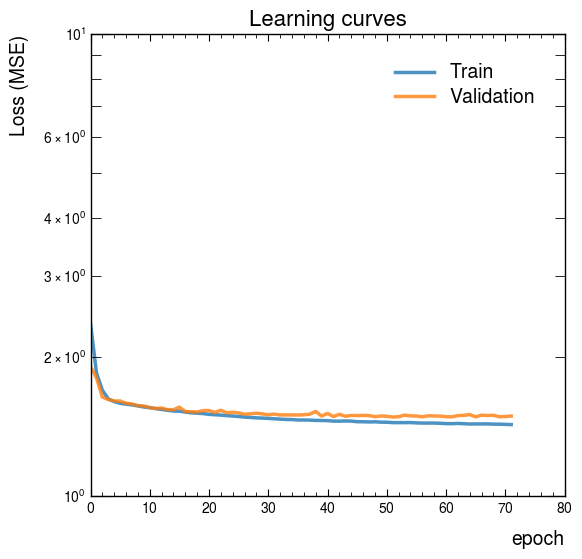

In [67]:
plot.plot_loss_history(history, logx=False, logy=True)

In [68]:
sig_truth_inv = ROBUST_INT.inverse_transform(sig_truth)
sig_pred_inv = ROBUST_INT.inverse_transform(sig_pred)

In [69]:
# Make a directory
dir_name = "./w_lead_result/"
name = "dnn_w_lead_full"

# save predicted results
np.savez_compressed(
    dir_name + name + "_data.npz", pred_y=sig_pred_inv, test_y=sig_truth_inv
)
sig_pred_inv = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth_inv = np.load(dir_name + name + "_data.npz")["test_y"]

Truth mean: -0.179, std: 43.797, min: -585.857, max: 637.177


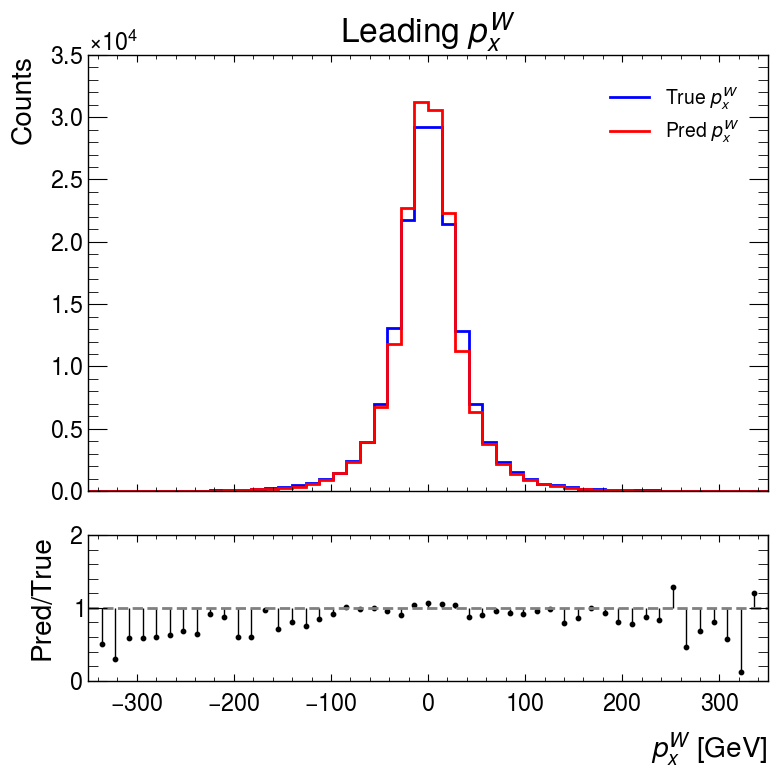

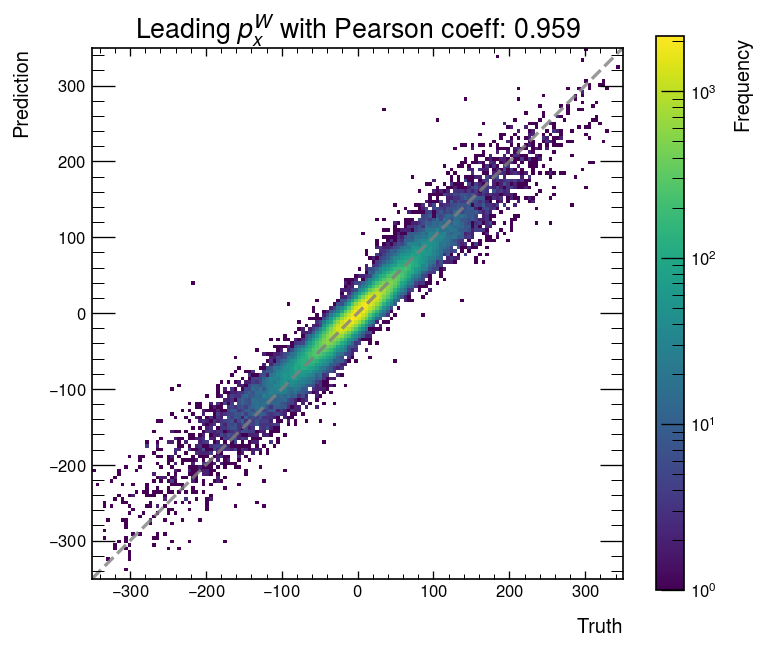

In [70]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,0]):.3f}, std: {np.std(sig_truth_inv[:,0]):.3f}, min: {np.min(sig_truth_inv[:,0]):.3f}, max: {np.max(sig_truth_inv[:,0]):.3f}"
)

range = [-350, 350]

plot.hist(
    data=[sig_truth_inv[:, 0], sig_pred_inv[:, 0]],
    label=r"$p_{x}^{W}$",
    title="Leading $p_{x}^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,0], sig_pred_inv[:,0])):.3f}",
    range=range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 0],
    sig_pred_inv[:, 0],
    r"Leading $p_{x}^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,0], sig_pred_inv[:,0])[0]:.3f}",
    range=range,
)

Truth mean: 0.128, std: 43.633, min: -755.579, max: 579.440


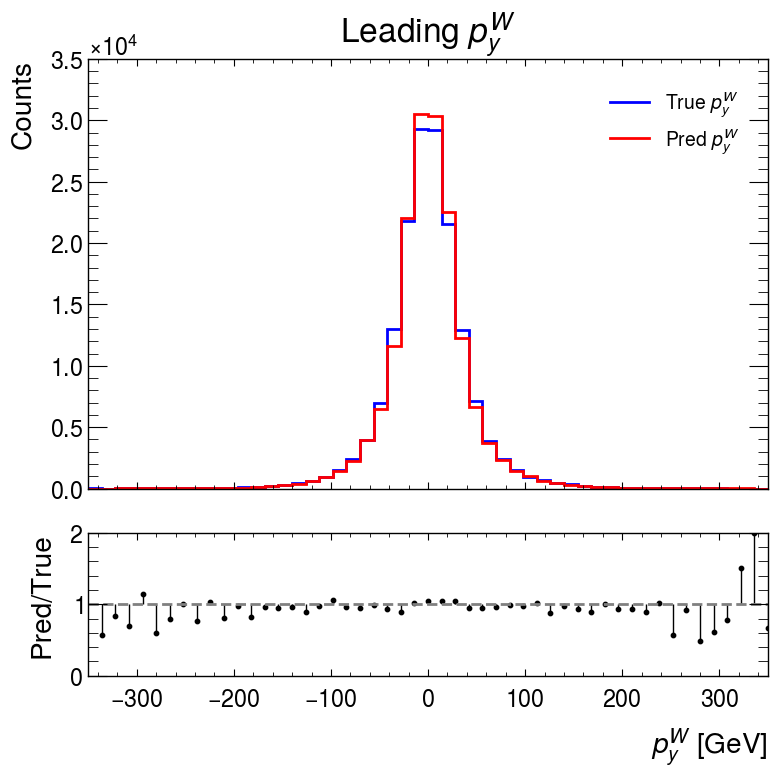

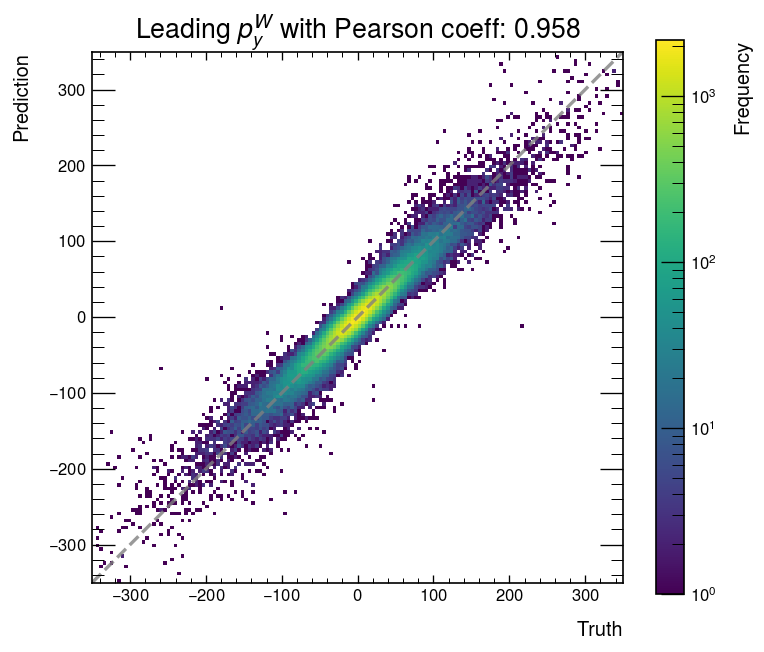

In [71]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,1]):.3f}, std: {np.std(sig_truth_inv[:,1]):.3f}, min: {np.min(sig_truth_inv[:,1]):.3f}, max: {np.max(sig_truth_inv[:,1]):.3f}"
)

range = [-350, 350]

plot.hist(
    data=[sig_truth_inv[:, 1], sig_pred_inv[:, 1]],
    label=r"$p_{y}^{W}$",
    title="Leading $p_{y}^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1])):.3f}",
    range=range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 1],
    sig_pred_inv[:, 1],
    r"Leading $p_{y}^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,1], sig_pred_inv[:,1])[0]:.3f}",
    range=range,
)

Truth mean: 0.625, std: 328.719, min: -3791.950, max: 3377.902


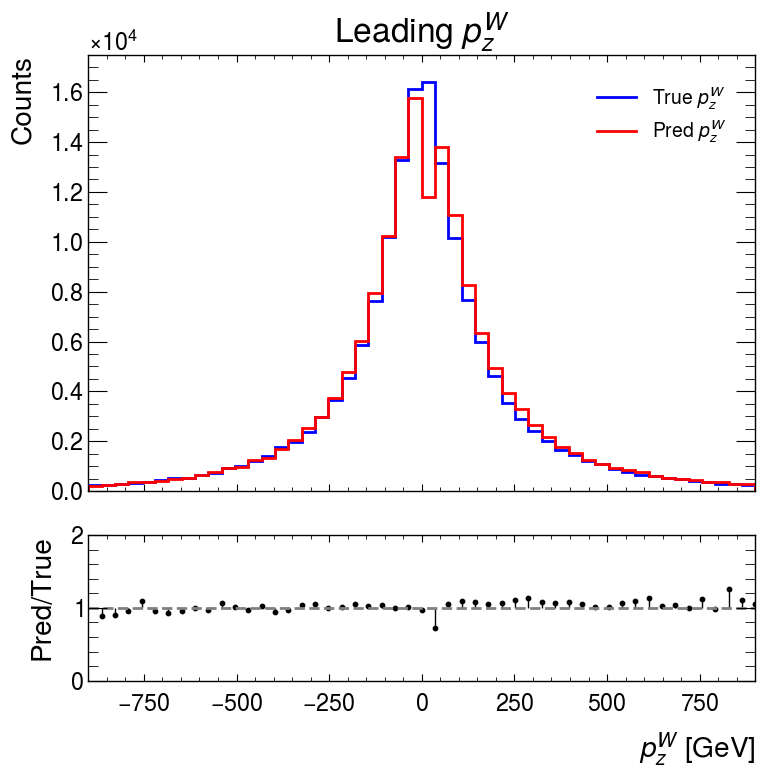

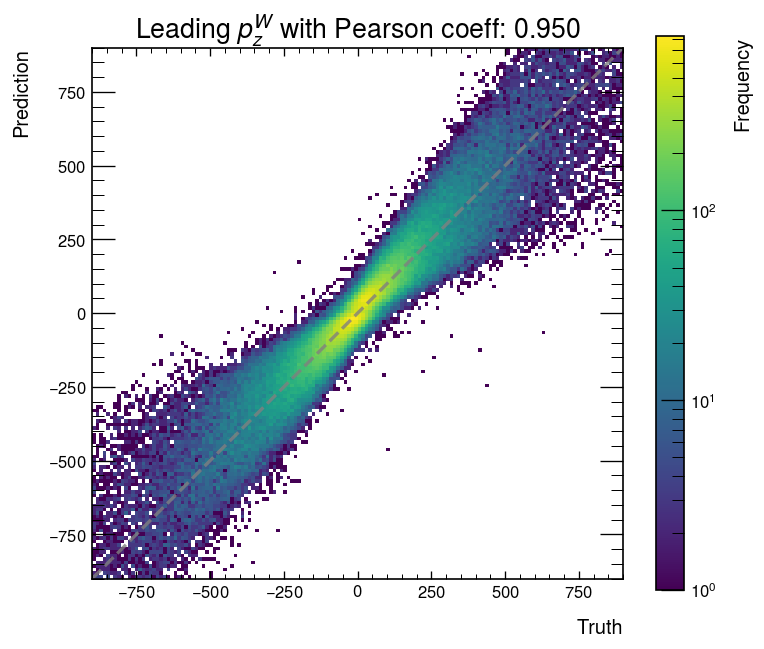

In [72]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,2]):.3f}, std: {np.std(sig_truth_inv[:,2]):.3f}, min: {np.min(sig_truth_inv[:,2]):.3f}, max: {np.max(sig_truth_inv[:,2]):.3f}"
)

range = [-900, 900]

plot.hist(
    data=[sig_truth_inv[:, 2], sig_pred_inv[:, 2]],
    label=r"$p_{z}^{W}$",
    title="Leading $p_{z}^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,2], sig_pred_inv[:,2])):.3f}",
    range=range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 2],
    sig_pred_inv[:, 2],
    r"Leading $p_{z}^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,2], sig_pred_inv[:,2])[0]:.3f}",
    range=range,
)

Truth mean: 239.454, std: 245.175, min: 37.882, max: 3792.856


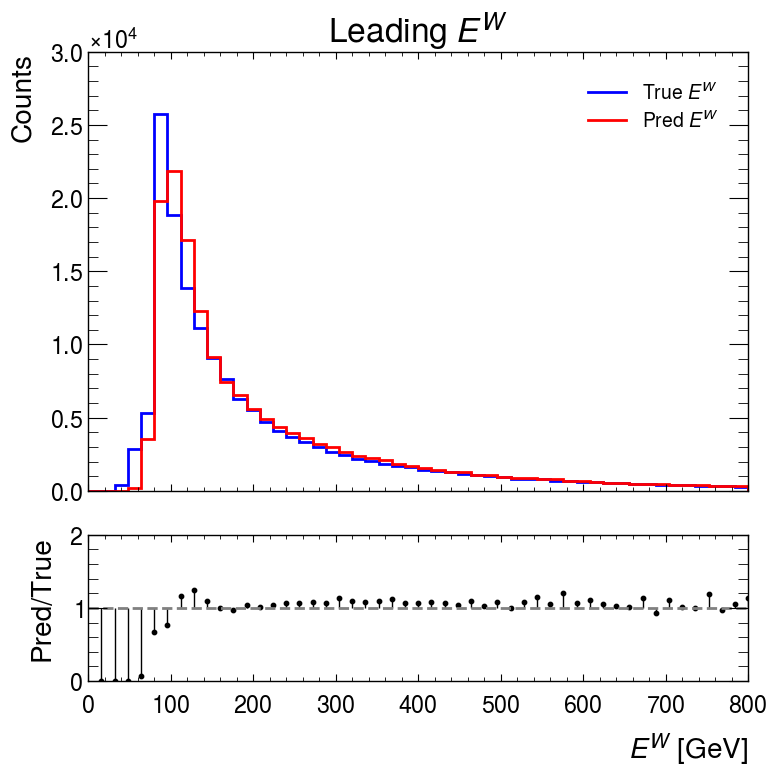

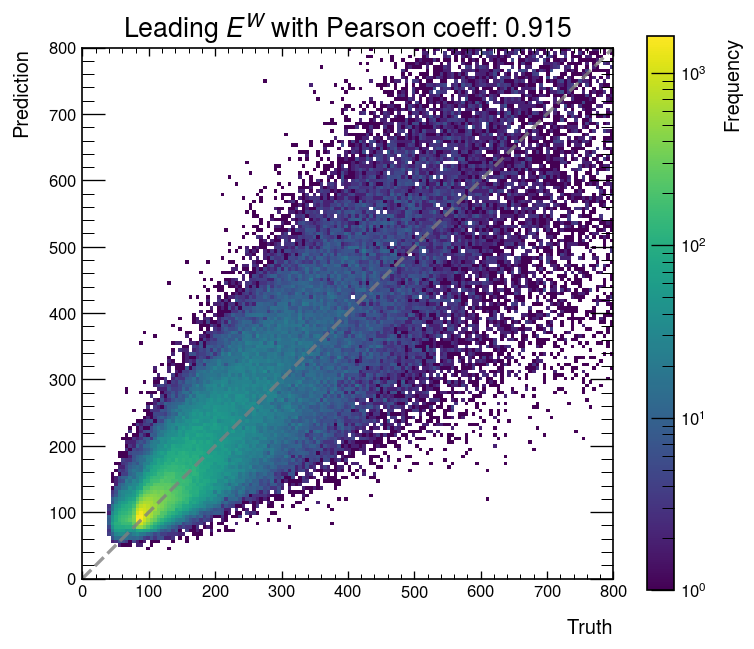

In [73]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,3]):.3f}, std: {np.std(sig_truth_inv[:,3]):.3f}, min: {np.min(sig_truth_inv[:,3]):.3f}, max: {np.max(sig_truth_inv[:,3]):.3f}"
)

range = [0, 800]

plot.hist(
    data=[sig_truth_inv[:, 3], sig_pred_inv[:, 3]],
    label=r"$E^{W}$",
    title="Leading $E^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,3], sig_pred_inv[:,3])):.3f}",
    range=range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 3],
    sig_pred_inv[:, 3],
    r"Leading $E^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,3], sig_pred_inv[:,3])[0]:.3f}",
    range=range,
)

In [74]:
# range = [0, 100]

# plot.hist(
#     data=[sig_truth_inv[:,4], sig_pred_inv[:,4]],
#     label=r"$m^{W}$",
#     title="Leading $m^{W}$",
#     # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,4], sig_pred_inv[:,4])):.3f}",
#     range=range,
#     unit = "[GeV]"
# )

# plot.plot_2d_histogram(
#     sig_truth_inv[:,4],
#     sig_pred_inv[:,4],
#     r"Leading $m^{W}$ "
#     + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,4], sig_pred_inv[:,4])[0]:.3f}",
#     range=range,
# )